In [1]:
import re
def load_the_data(data_set):
    with open("train_dev/en-"+data_set+".conll", 'r') as f:
        data=f.read()
        data=data.split('\n\n')
        
    lines=[]
        
    for ind, sentence in enumerate(data):
        lines.append(data[ind].split('\n')[2:])
    
    snt=[]
    for sentences in lines:
        ow=[]
        for word in sentences:
            mtch = re.match(r"(.*) _ _ (.*)", word)
            ow.append(mtch.groups())
        snt.append(ow)
    
    return snt

    
    


In [2]:
dev_set=load_the_data('dev')
training_set=load_the_data('train')

In [3]:
class NERDataMaker:
    def __init__(self, texts):
        self.unique_entities = []
        self.processed_texts = []

        temp_processed_texts = []
        for text in texts:
            for _, ent in text:
                if ent not in self.unique_entities:
                    self.unique_entities.append(ent)
            temp_processed_texts.append(text)

        self.unique_entities.sort(key=lambda ent: ent if ent != "O" else "")

        for tokens_with_entities in temp_processed_texts:
            self.processed_texts.append([(t, self.unique_entities.index(ent)) for t, ent in tokens_with_entities])
            
    #@property decorator is a built-in python feature allowing a method to be accessed like an attribute
    @property
    def id2label(self):
        return dict(enumerate(self.unique_entities))
    
    @property
    def label2id(self):
        return {v:k for k, v in self.id2label.items()}
    
    def __len__(self):
        return len(self.processed_texts)
    
    def __getitem__(self, idx):
        def _process_tokens_for_one_text(id, tokens_with_encoded_entities):
            ner_tags=[]
            tokens=[]
            
            for t , ent in tokens_with_encoded_entities:
                ner_tags.append(ent)
                tokens.append(t)
                
            return {
                'id':id,
                'ner_tags':ner_tags,
                'tokens':tokens
            }
        
        tokens_with_encoded_entities=self.processed_texts[idx]
        
        if isinstance(idx, int):
            return _process_tokens_for_one_text(idx, tokens_with_encoded_entities)
        
        else:
            return [_process_tokens_for_one_text(i+idx.start, tee) for i, tee in enumerate(tokens_with_encoded_entities)]
        
    
    
    def as_hf_dataset(self, tokenizer):
        from datasets import Dataset, Features, Value, ClassLabel, Sequence
        
        ids, ner_tags, tokens = [], [], []
        for i, pt in enumerate(self.processed_texts[:len(self.processed_texts)-1]):
            ids.append(i)
            pt_tokens,pt_tags =list(zip(*pt))
            ner_tags.append(pt_tags)
            tokens.append(pt_tokens)
            
            
        data = {
            "id": ids,
            "ner_tags": ner_tags,
            "tokens": tokens
        }
        
        
        features = Features({
            "tokens": Sequence(Value("string")),
            "ner_tags": Sequence(ClassLabel(names=dm.unique_entities)),
            "id": Value("int32")
        })
        
        ds = Dataset.from_dict(data, features)
        
        def tokenize_and_align_labels(examples):
            tokenized_inputs = tokenizer(examples["tokens"], truncation=True,padding='max_length',
                                         max_length=30, is_split_into_words=True)#padding='max_length', max_length=30)

            labels = []
            for i, label in enumerate(examples[f"ner_tags"]):
                word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
                previous_word_idx = None
                label_ids = []
                for word_idx in word_ids:  # Set the special tokens to -100.
                    if word_idx is None:
                        label_ids.append(-100)
                    elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                        label_ids.append(label[word_idx])
                    else:
                        label_ids.append(-100)
                    previous_word_idx = word_idx
                labels.append(label_ids)

            tokenized_inputs["labels"] = labels
            return tokenized_inputs


        tokenized_ds = ds.map(tokenize_and_align_labels, batched=True)
        return tokenized_ds

    
    

In [4]:
from transformers import BertTokenizerFast, BertModel


tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

dm=NERDataMaker(training_set)


dm_val=NERDataMaker(dev_set)


In [5]:
#from transformers import DataCollatorForTokenClassification, BertModel, TrainingArguments, Trainer
#data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
#model_config = BertModel.from_pretrained("bert-base-cased", num_labels=len(dm.unique_entities), id2label=dm.id2label, label2id=dm.label2id)

In [6]:
import torch.nn as nn
from transformers import BertConfig
from transformers.models.bert import BertPreTrainedModel
from transformers.modeling_outputs import TokenClassifierOutput

class BertModelForTokenClassifaction(BertPreTrainedModel):
    config_class=BertModel
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.bert = BertModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions) 
    

In [7]:
import torch
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

from transformers import AutoConfig

bert_config = AutoConfig.from_pretrained(bert_model_name,
                                         num_labels=len(dm.unique_entities),
                                         id2label=dm.id2label, label2id=dm.label2id)



In [8]:
xlmr_model = (BertModelForTokenClassifaction
              .from_pretrained(bert_model_name, config=bert_config)
              .to(device))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModelForTokenClassifaction: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModelForTokenClassifaction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModelForTokenClassifaction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModelForTokenClassif

In [9]:
train_ds = dm.as_hf_dataset(tokenizer=tokenizer)
valid_ds=dm.as_hf_dataset(tokenizer=tokenizer)

Parameter 'function'=<function NERDataMaker.as_hf_dataset.<locals>.tokenize_and_align_labels at 0x2bc0348b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

In [10]:
#xlmr_model(torch.tensor(hf_dm['input_ids']).to(device)).logits
outputs=xlmr_model(torch.tensor(train_ds['input_ids'][0:3]).to(device)).logits

In [11]:
predictions = torch.argmax(outputs, dim=-1)
print(f"Shape of outputs: {outputs.shape}")

predictions




Shape of outputs: torch.Size([3, 30, 67])


tensor([[47, 47, 32, 58, 47, 38, 15, 11, 47, 62,  0, 55, 20, 23, 23,  4, 32, 15,
         47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47],
        [36, 36, 61, 50, 55, 11, 46, 23,  7, 23, 11, 23, 55, 23,  0, 62, 47,  6,
         32,  6, 39, 39, 47, 47, 47, 39, 39, 39,  6,  6],
        [36,  6, 47, 11, 47, 47, 32, 47, 23, 47, 22,  0, 47, 23, 47, 47, 47, 20,
         23,  6, 47, 47, 34, 34, 47, 34, 34, 11, 11, 11]], device='mps:0')

In [12]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=20,
    weight_decay=0.01,
)



trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds, # eval on training set! ONLY for DEMO!!
    tokenizer=tokenizer,
    data_collator=data_collator,
)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
train_ds

Dataset({
    features: ['id', 'ner_tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 16778
})

In [14]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely ignore this message.
/opt/miniconda3/envs/torch/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16778
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 2640
  Number of trainable parameters = 107771203
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: joesharratt1229 (joes_team). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.501455
2,No log,0.319939
3,No log,0.244816
4,0.538200,0.197378
5,0.538200,0.165856
6,0.538200,0.138295
7,0.538200,0.117855
8,0.193500,0.099812
9,0.193500,0.084859
10,0.193500,0.073846


The following columns in the evaluation set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16778
  Batch size = 128
The following columns in the evaluation set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16778
  Batch size = 128
The following columns in the evaluation set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely

The following columns in the evaluation set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16778
  Batch size = 128
The following columns in the evaluation set don't have a corresponding argument in `BertModelForTokenClassifaction.forward` and have been ignored: tokens, ner_tags, id. If tokens, ner_tags, id are not expected by `BertModelForTokenClassifaction.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 16778
  Batch size = 128


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2640, training_loss=0.1907931701703505, metrics={'train_runtime': 35145.9184, 'train_samples_per_second': 9.548, 'train_steps_per_second': 0.075, 'total_flos': 5140562475218400.0, 'train_loss': 0.1907931701703505, 'epoch': 20.0})

In [55]:
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    #convert dict of lists to list of dicts suitable for data collator
    
    features=[dict(zip(batch, t)) for t in zip(*batch.values())]
    #pad inputs and labels putting all tensors on device
    batch=data_collator(features)
    input_ids=batch['input_ids']
    attention_mask=batch['attention_mask']
    labels=batch['labels']
    
    with torch.no_grad():
        
        output=trainer.model(input_ids, attention_mask)
        
        predicted_label=torch.argmax(output.logits, axis=-1).cpu().numpy()
        
        
    loss=cross_entropy(output.logits.view(-1, 67),
                      labels.view(-1), reduction='none')
    
    loss=loss.view(len(input_ids),-1).cpu().numpy()
    
    return {'loss':loss, 'predicted_label':predicted_label}
    

In [56]:
train_ds

Dataset({
    features: ['id', 'ner_tags', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 16778
})

In [57]:

train_ds.remove_columns(column_names=['id', 'ner_tags', 'tokens','token_type_ids'])
valid_ds1=valid_ds.remove_columns(column_names=['id', 'ner_tags', 'tokens', 'token_type_ids'])


In [58]:
valo_seto=valid_ds1.map(forward_pass_with_labels, batched=True, batch_size=128)

df_new=valo_seto.to_pandas()

  0%|          | 0/132 [00:00<?, ?ba/s]

In [61]:
df_new.head(5)

,input_ids,attention_mask,labels,loss,predicted_label
0,"[101, 11580, 3740, 1400, 2145, 17436, 1377, 30...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 20, -100, 53, -100, -100, -100, 0, 32, ...","[0.0, 0.11211958, 0.0, 0.07210466, 0.0, 0.0, 0...","[0, 20, 53, 53, 53, 53, 53, 0, 32, 65, 0, 0, 0..."
1,"[101, 1219, 1103, 5436, 1104, 1103, 11371, 140...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 20, -100, -100, 53, 0, 0...","[0.0, 9.941561e-05, 0.00011216965, 0.000131955...","[0, 0, 0, 0, 0, 0, 20, 53, 53, 53, 0, 0, 0, 0,..."
2,"[101, 1748, 1844, 1521, 1107, 1103, 3266, 1106...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 20, -100, -100,...","[0.0, 8.7257395e-05, 8.928377e-05, 8.439662e-0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0,..."
3,"[101, 1103, 4133, 1127, 2234, 1118, 1209, 1833...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 20, -100, 53, -100, 0, 0...","[0.0, 9.595887e-05, 0.000110739296, 0.00010048...","[0, 0, 0, 0, 0, 0, 20, 25, 58, 58, 0, 0, 0, 0,..."
4,"[101, 24438, 3556, 2007, 1361, 182, 2155, 1926...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 20, -100, -100, -100, 53, -100, -100, 0...","[0.0, 0.041200228, 0.0, 0.0, 0.0, 0.031126363,...","[0, 20, 53, 53, 53, 53, 53, 53, 0, 0, 0, 0, 0,..."


In [63]:
indx_to_tag=dm.id2label

In [68]:
indx_to_tag[-100]='IGN'

df_new['input_tokens']=df_new['input_ids'].apply(
    lambda x : tokenizer.convert_ids_to_tokens(x))



In [81]:
import pandas as pd

df_tokens_explode=df_new.apply(pd.Series.explode)
df_tokens_explode_new=df_tokens_explode.query("labels!= 'IGN'")

df_tokens_explode_new["loss"] = df_tokens_explode_new["loss"].astype(float).round(2)
df_tokens_explode_new.head(7)

/var/folders/1q/q1xm4z_j5cgdswpvb5n90pc00000gn/T/ipykernel_4185/2335910542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens_explode_new["loss"] = df_tokens_explode_new["loss"].astype(float).round(2)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,11580,1,B-OtherPER,0.11,B-OtherPER,robe
0,1400,1,I-OtherPER,0.07,I-OtherPER,got
0,3061,1,O,0.00,O,1939
0,8717,1,B-VisualWork,0.01,B-VisualWork,academy
0,2574,1,I-VisualWork,0.01,I-VisualWork,award
0,2981,1,O,0.00,O,winner
0,1105,1,O,0.00,O,and


In [88]:
len(df_tokens_explode_new[df_tokens_explode_new['labels']==df_tokens_explode_new['predicted_label']])/len(df_tokens_explode_new)  #99.17 accuracy

0.9917204466505259

In [92]:
(
    df_tokens_explode_new.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(20)
)

,labels,count,mean,sum
0,B-OtherPER,1760,0.35,609.76
1,I-OtherPER,2207,0.22,482.04
2,B-ORG,1471,0.29,426.35
3,B-Athlete,1748,0.22,389.73
4,B-Politician,1033,0.34,352.92
5,I-Athlete,1730,0.18,314.30
6,O,193882,0.00,306.52
7,B-Artist,3649,0.07,257.53
8,I-Politician,1388,0.18,256.63
9,B-PrivateCorp,197,1.14,223.81


In [113]:
#We see that the model has most difficulty determining B-other per 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm=confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax=plt.subplots(figsize=(30,30))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalised Confusion Matrix')
    plt.show()

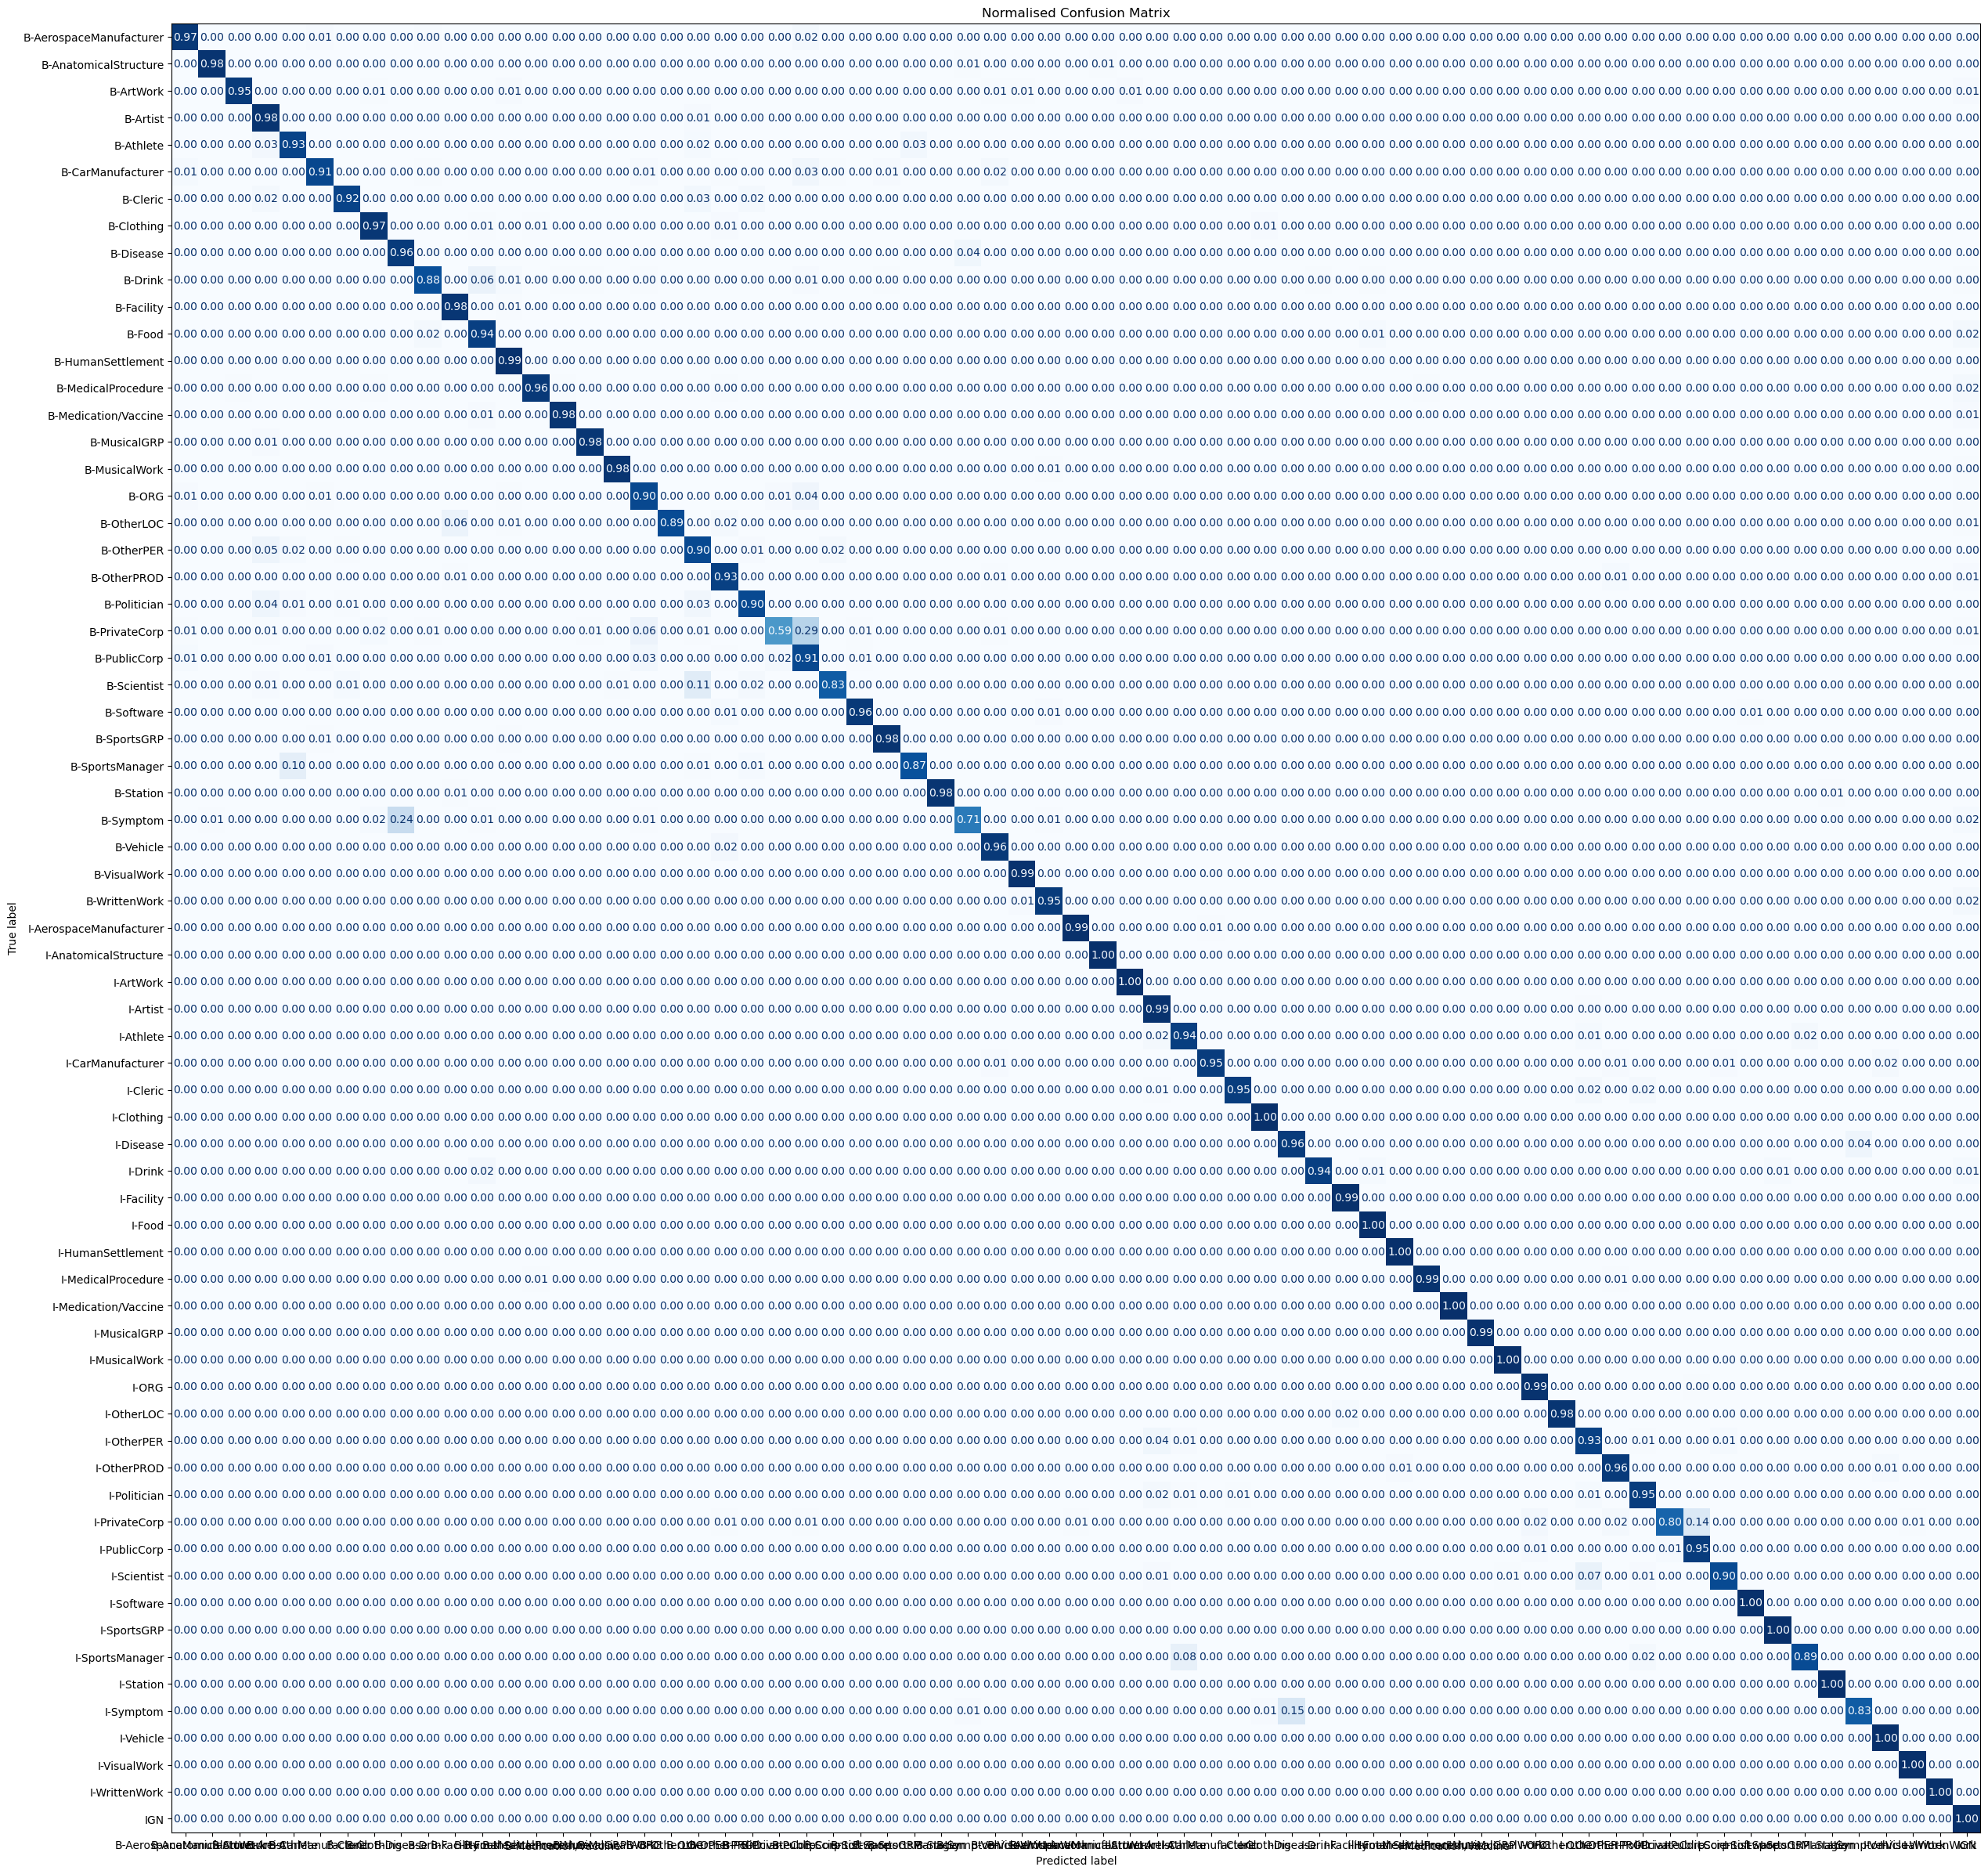

In [114]:
import matplotlib.pyplot as plt

vals=list(indx_to_tag.values())[1:]

plot_confusion_matrix(df_tokens_explode_new['predicted_label'], df_tokens_explode_new['labels'], vals)

In [124]:
trainer.save_model('models/bert_ner_fine_tuned')

Saving model checkpoint to models/bert_ner_fine_tuned
Configuration saved in models/bert_ner_fine_tuned/config.json
Model weights saved in models/bert_ner_fine_tuned/pytorch_model.bin
tokenizer config file saved in models/bert_ner_fine_tuned/tokenizer_config.json
Special tokens file saved in models/bert_ner_fine_tuned/special_tokens_map.json
